# Calculating EOFs & PCs using the 'eofs' package

## Import the sst data from a netcdf file or multiple netcdf files

In [ ]:
#! conda install -c conda-forge eofs

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from eofs.standard import Eof
%matplotlib inline
from glob import glob
import os
#import warnings
#warnings.simplefilter("ignore") 

## load the SST data from files using xarray

In [2]:
ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/\
                       .version4/.anom/T/-23.5/last/RANGE/dods',decode_times=False)

ds['T'] = pd.date_range('1/1/1958', periods=ds.anom.shape[0], freq='MS').shift(15, freq='D')
ds

<xarray.Dataset>
Dimensions:  (T: 735, X: 180, Y: 89, zlev: 1)
Coordinates:
  * Y        (Y) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * zlev     (zlev) float32 0.0
  * T        (T) datetime64[ns] 1958-01-16 1958-02-16 1958-03-16 1958-04-16 ...
Data variables:
    anom     (T, zlev, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [3]:
ds2 = ds.drop(['zlev']).squeeze().sel(T=slice('1958-01-01','2014-12-01'))

In [4]:
dpac = ds2.sel(Y=slice(-40,40), X=slice(120,290))
ds_annual = dpac.resample(T='AS').mean(dim='T')
ds_anom = ds_annual - ds_annual.mean(dim='T')

### define weights

In [5]:
coslat = np.cos(np.deg2rad(dpac.Y))
ds_anom['wgts'] = np.sqrt(coslat) + 0*dpac.X
np.shape(ds_anom.anom.values)

(57, 41, 86)

### instantiates the EOF solver, passing the weights array as an optional argument

In [6]:
solver = Eof(ds_anom.anom.values, weights=ds_anom.wgts.values)

### get the EOFs (spatial patterns) as correlations

In [7]:
number_of_eofs = 4
Ss = solver.eofsAsCovariance(neofs=number_of_eofs)
ds_anom['ev'] = np.arange(0,number_of_eofs)
ds_anom['Ss'] = (['ev','Y','X'],Ss)

### get the Principal Components (PCs), normalized values

In [8]:
Ts = solver.pcs(npcs=number_of_eofs, pcscaling=1)
ds_anom['Ts'] = (['ev','T'],Ts.T)

### plots 

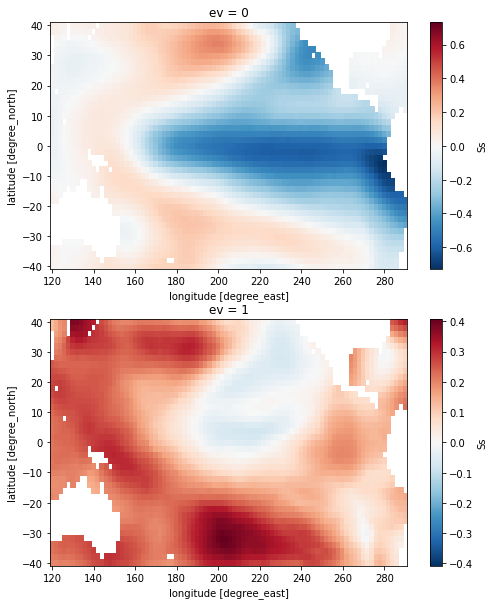

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(211)
ds_anom.Ss[0].plot()
plt.subplot(212)
ds_anom.Ss[1].plot()

Text(0.5,1,'PC2')

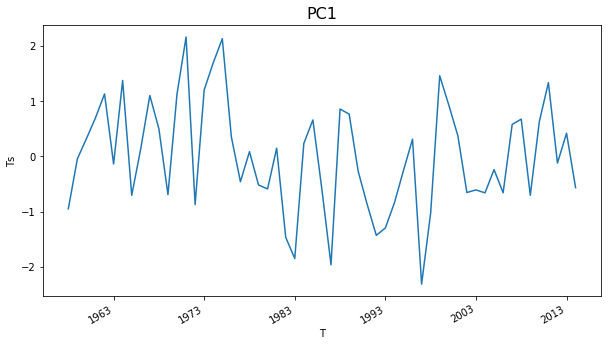

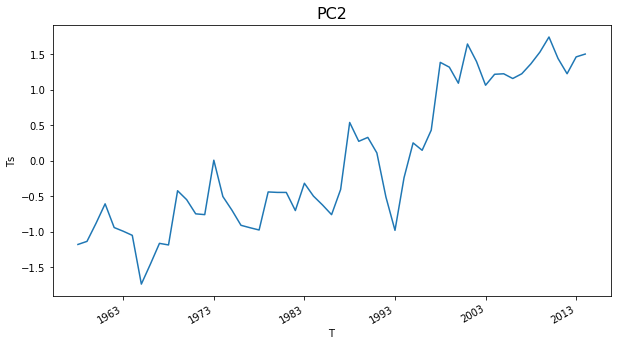

In [10]:
ds_anom.Ts[0].plot(figsize=(10,5)); plt.title('PC1',fontsize=16)
ds_anom.Ts[1].plot(figsize=(10,5)); plt.title('PC2',fontsize=16)

In [11]:
ds_anom.to_netcdf('python_EOF.nc',encoding={'T':{'dtype':'float32'}})

/home2/nhn2/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [39]:
pc1 = ds_anom.Ts[0]
eof1 = ds_anom.Ss[0]
[nx,ny] = eof1.shape

In [40]:
nx,ny

(41, 86)

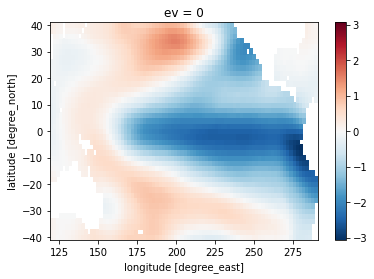

In [43]:
# to scale like ingrid:
scale = np.sqrt((eof1*eof1*(ds_anom.wgts)/nx/ny).sum())
(eof1/scale).plot()